# Data Augmentation

Since the dataset is small, containing only 253 images segregated into two folders, yes and no, we will be using the concept of Data Augmentation to add new samples to our training dataset.

## Import Necessary Modules

In [23]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.metrics import f1_score
from os import listdir
from tensorflow.keras.models import load_model
import imutils
from sklearn.utils import shuffle
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        
        # load the image
        image = cv2.imread(file_dir + '/' + filename)
        
        # reshape the image
        image = image.reshape((1,)+image.shape)
        
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

We have approximately 61% images as non tumorous and 39% as tumorous. In order to balance the dataset, we will generate 6 tumorous images for every 9 non tumorous ones. 

In [ ]:
augmented_data_path = '/content/drive/MyDrive/augmented data/'

yes_path = "/content/drive/MyDrive/yes/"
no_path = "/content/drive/MyDrive/no/"

# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')

# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')

Let's see how many tumorous and non-tumorous examples after performing data augmentation:

In [6]:
augmented_data_path = '/content/drive/MyDrive/augmented data/'

yes_path = augmented_data_path + "yes"
no_path = augmented_data_path + "no"

n_pos = len(listdir(yes_path))
n_neg = len(listdir(no_path))

m = n_pos + n_neg

per_pos = n_pos/m
per_neg = n_neg/m

print("Percentage of positive example - {:.2f}".format(per_pos*100))
print("Percentage of negative example - {:.2f}".format(per_neg*100))

Percentage of positive example - 52.54
Percentage of negative example - 47.46


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


That's it for this notebook. Now, we can use the augmented data to train our convolutional neural network.

# Data Preprocessing and Preparation

We are now going to preprocess our data before feeding it to our neural network for training. 

Lets try cropping out the part of the images containing only the brain. We do this by means of the function, crop_image(). Reference - [Finding extreme points in contours with opencv](https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)

In [7]:
def crop_image(image):
    
     # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    return new_image

We will now be loading up our data and finally, be ready to train our neural network. We take the images from the folders named 'yes' and 'no' that we augmented earlier and perform the follwing on each file - 

1. Read the Image.
2. Crop the image to contain only the brain part.
3. Resize the image to (240, 240, 3).
4. Normalize the pixel values to lie in the range of (0-1).
5. Append the image to X and its label to y.

In [8]:
X = []
y = []

image_height, image_width = (240,240)

#Path for yes and no folders in the augmented data
augment_yes = augmented_data_path + 'yes'
augment_no = augmented_data_path + 'no'

for directory in [augment_yes, augment_no]:
    for file in listdir(directory):
        
        #read image
        image = cv2.imread(directory + '/' + file)
        
        #crop image
        image = crop_image(image)
        
        #Resize the image
        image = cv2.resize(image, dsize = (image_width, image_height), interpolation = cv2.INTER_CUBIC)
        
        #Normalize the image
        image = image/255.0
        
        #Appending x and y
        X.append(image)
        
        if(directory[-3:] == 'yes'):
            y.append([1])
        
        else:
            y.append([0])
            
X = np.array(X)
y = np.array(y)

#shuffle the dataset
X,y = shuffle(X,y)

Lets have a look at the number of examples and shape of our dataset

In [9]:
print(f'The total number of images = {len(X)}')
print(f'The shape of X = {X.shape}')
print(f'The shape of Y = {y.shape}')

The total number of images = 2065
The shape of X = (2065, 240, 240, 3)
The shape of Y = (2065, 1)


## Plotting Sample Images

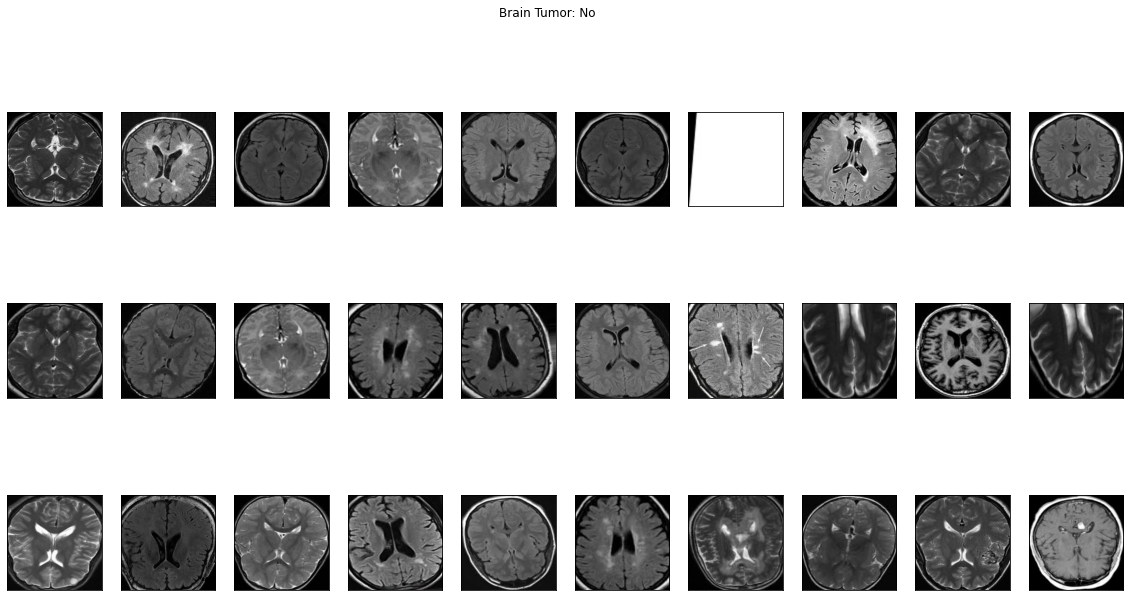

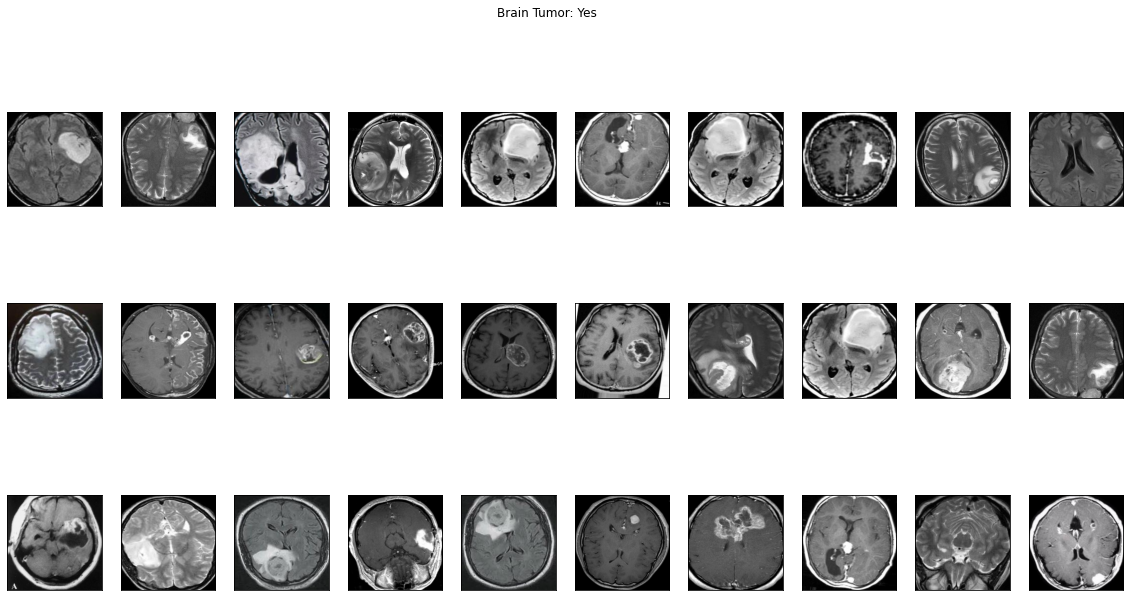

In [10]:
def plot_sample_images(X, y, n=30):
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()
        
plot_sample_images(X, y)

## Split the dataset - 

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size = 0.3)

print(f'Training set size - {X_train.shape}')
print(f'Test set size - {X_valid.shape}')

Training set size - (1445, 240, 240, 3)
Test set size - (620, 240, 240, 3)


# Building the model 

I am trying to build a Convolutional Neural Network for the classification task at hand. The architecture is fairly simple, we stack two consecutive layers of Convolution, Batch Normalization and Max Pooling which finally connects to an Output neuron with sigmoidal activation.

In [11]:
model = keras.models.Sequential([
    keras.layers.Input(shape = (image_width, image_height, 3)),
    
    keras.layers.ZeroPadding2D((2,2)),
    
    keras.layers.Conv2D(32, (7,7), strides = (1,1), activation = 'relu'),
    keras.layers.BatchNormalization(axis = 3),
    keras.layers.MaxPooling2D((4,4)),
    
    keras.layers.Conv2D(11, (3,3), strides = (1,1), activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 32)      4736      
                                                                 
 batch_normalization (BatchN  (None, 238, 238, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 11)        3179      
                                                        

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
#tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [16]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid), callbacks=[tensorboard])

Epoch 1/20
46/46 [==============================] - 148s 3s/step - loss: 0.6564 - accuracy: 0.7080 - val_loss: 0.6695 - val_accuracy: 0.5339
Epoch 2/20
46/46 [==============================] - 138s 3s/step - loss: 0.4081 - accuracy: 0.8180 - val_loss: 0.6428 - val_accuracy: 0.6258
Epoch 3/20
46/46 [==============================] - 145s 3s/step - loss: 0.2579 - accuracy: 0.8976 - val_loss: 0.5620 - val_accuracy: 0.7726
Epoch 4/20
46/46 [==============================] - 145s 3s/step - loss: 0.1731 - accuracy: 0.9398 - val_loss: 0.5295 - val_accuracy: 0.7435
Epoch 5/20
46/46 [==============================] - 145s 3s/step - loss: 0.1291 - accuracy: 0.9578 - val_loss: 0.4952 - val_accuracy: 0.7435
Epoch 6/20
46/46 [==============================] - 145s 3s/step - loss: 0.0840 - accuracy: 0.9758 - val_loss: 0.4584 - val_accuracy: 0.8048
Epoch 7/20
46/46 [==============================] - 145s 3s/step - loss: 0.0578 - accuracy: 0.9924 - val_loss: 0.6167 - val_accuracy: 0.6694
Epoch 8/20
46

In [17]:
history = model.history.history

# Plotting training and test metrics


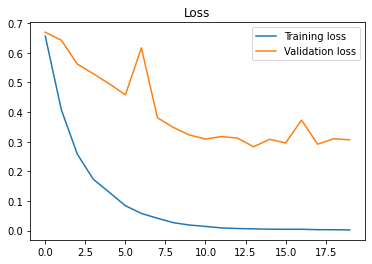

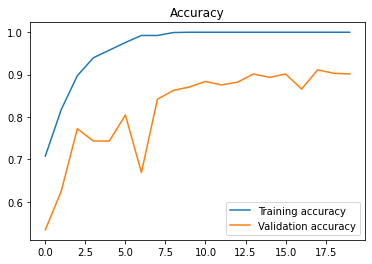

In [19]:
train_loss = history['loss']
train_acc = history['accuracy']
val_loss = history['val_loss']
val_acc = history['val_accuracy']

#Plotting loss
plt.figure()
plt.plot(train_loss, label = "Training loss")
plt.plot(val_loss, label = "Validation loss")
plt.title("Loss")
plt.legend()
plt.show()

#Plotting accuracy
plt.figure()
plt.plot(train_acc, label = "Training accuracy")
plt.plot(val_acc, label = "Validation accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()